
# Diabetes Prediction Project (End-to-End)

**Deadline:** 10th September  
This notebook demonstrates the full ML workflow:
- Data Collection & Preprocessing (cleaning, normalization, handling zero-as-missing)
- Model Training (multiple algorithms)
- Evaluation (train/test split, accuracy, confusion matrix, ROC AUC)
- Visualization (histograms, correlation, ROC, confusion matrix)
- Export (pickle)
- Quick demo prediction

> Dataset: `diabetes.csv`


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:

# Load dataset (place diabetes.csv in the same folder as this notebook)
import os
csv_path = "diabetes.csv"
assert os.path.exists(csv_path), f"Dataset not found at {csv_path}"
df = pd.read_csv(csv_path)
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Missing values per column:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Zero counts (to be treated as missing) in selected columns:
 {'Glucose': 5, 'BloodPressure': 35, 'SkinThickness': 227, 'Insulin': 374, 'BMI': 11}

Class balance:
 Outcome
0    500
1    268
Name: count, dtype: int64


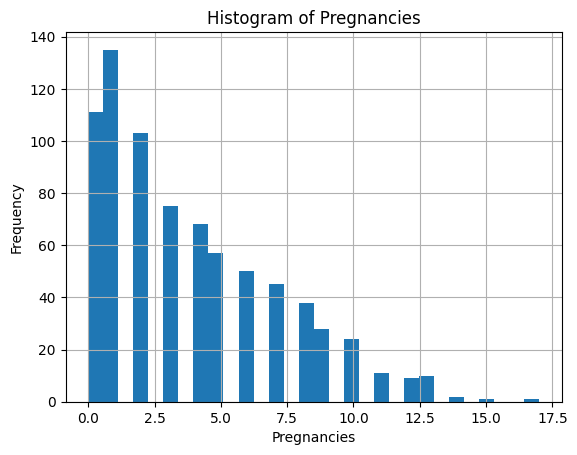

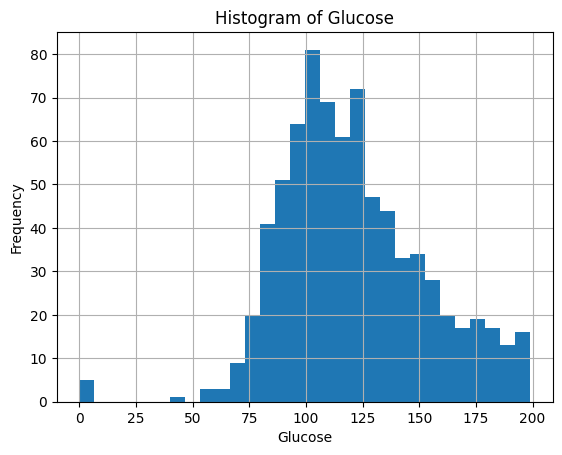

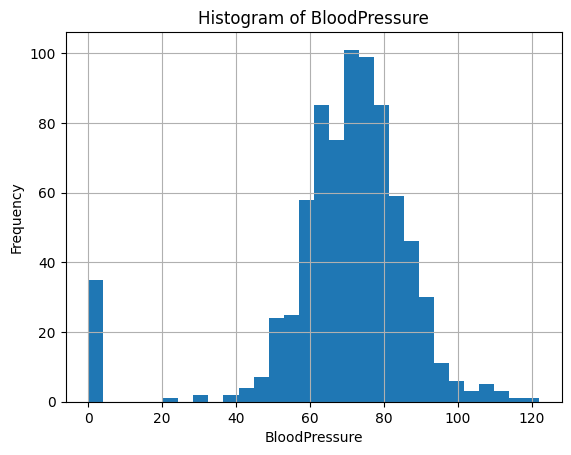

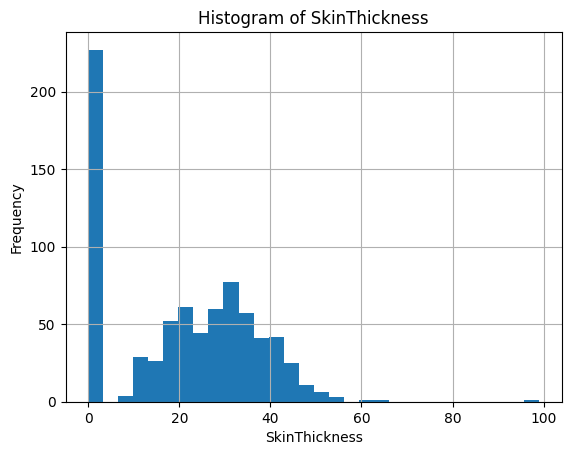

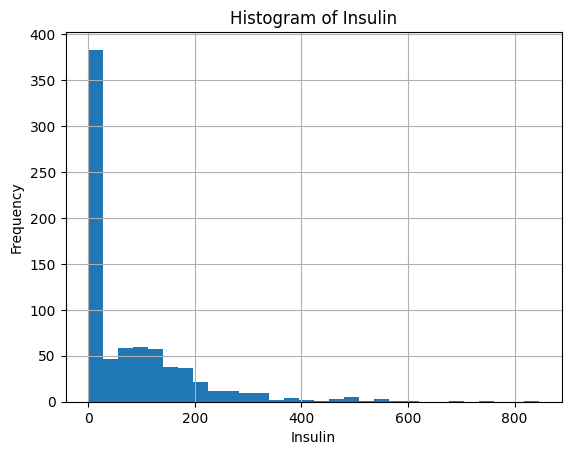

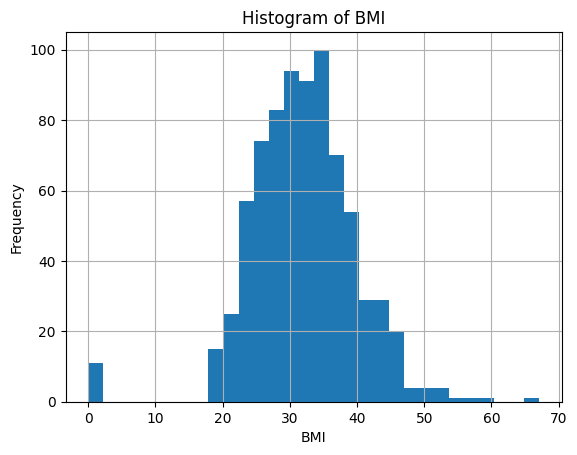

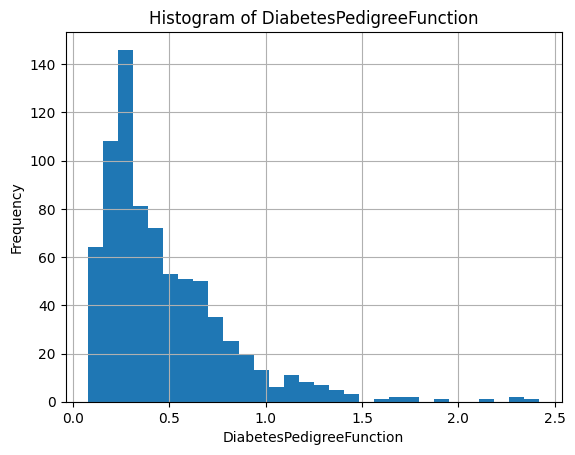

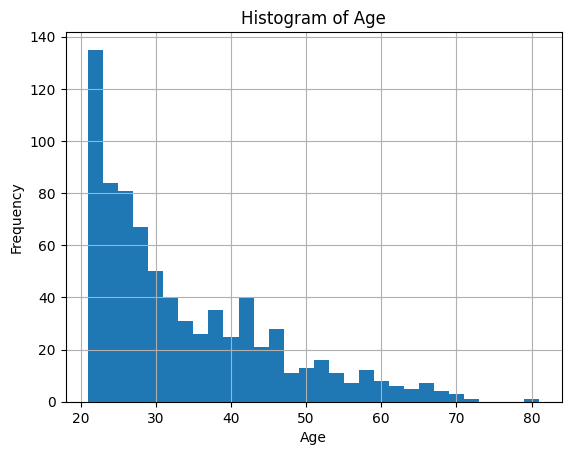

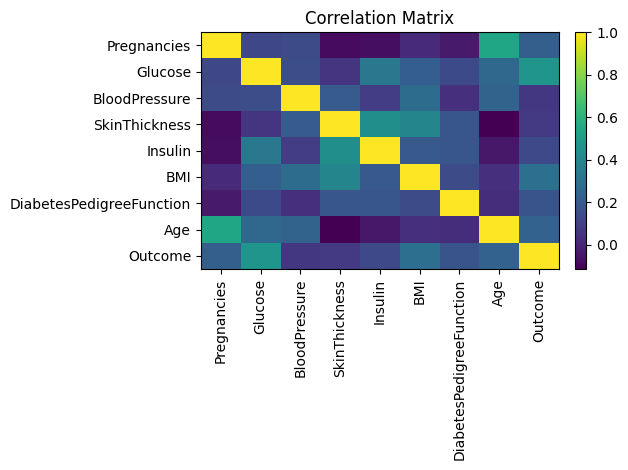

In [3]:

# Basic info and EDA
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nMissing values per column:\n", df.isna().sum())

zero_as_missing_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
zero_counts = {c: int((df[c] == 0).sum()) for c in zero_as_missing_cols if c in df.columns}
print("\nZero counts (to be treated as missing) in selected columns:\n", zero_counts)

print("\nClass balance:\n", df["Outcome"].value_counts().sort_index())

# Histograms
numeric_cols = [c for c in df.columns if c != "Outcome"]
for col in numeric_cols:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.show()

# Correlation
corr = df[numeric_cols + ["Outcome"]].corr(numeric_only=True)
plt.figure()
im = plt.imshow(corr.values, aspect="auto")
plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, rotation=90)
plt.yticks(ticks=np.arange(len(corr.index)), labels=corr.index)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


In [4]:

X = df.drop(columns=["Outcome"])
y = df["Outcome"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)


In [5]:

all_feature_cols = list(X.columns)
zero_impute_cols = [c for c in ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"] if c in all_feature_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("impute_zeros", SimpleImputer(missing_values=0, strategy="median"), zero_impute_cols),
    ],
    remainder="passthrough"
)

def build_pipeline(model):
    return Pipeline(steps=[
        ("preprocess", preprocess),
        ("scaler", StandardScaler()),
        ("model", model)
    ])

candidates = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE),
    "SVC_RBF": SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=RANDOM_STATE)
}

from sklearn.model_selection import StratifiedKFold, cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rows = []
for name, model in candidates.items():
    pipe = build_pipeline(model)
    auc_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc")
    acc_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy")
    rows.append({
        "Model": name,
        "CV ROC AUC (mean)": float(np.mean(auc_scores)),
        "CV ROC AUC (std)": float(np.std(auc_scores)),
        "CV Accuracy (mean)": float(np.mean(acc_scores)),
        "CV Accuracy (std)": float(np.std(acc_scores)),
    })

cv_df = pd.DataFrame(rows).sort_values(by=["CV ROC AUC (mean)", "CV Accuracy (mean)"], ascending=False)
cv_df


,Model,CV ROC AUC (mean),CV ROC AUC (std),CV Accuracy (mean),CV Accuracy (std)
0,LogisticRegression,0.844381,0.016074,0.762202,0.011053
2,SVC_RBF,0.837141,0.030934,0.760536,0.033953
1,RandomForest,0.818870,0.024231,0.763828,0.024804


BEST MODEL: LogisticRegression
Test Accuracy:  0.7338
Precision:      0.6032
Recall:         0.7037
F1-Score:       0.6496
ROC AUC:        0.8126

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.75      0.79       100
           1       0.60      0.70      0.65        54

    accuracy                           0.73       154
   macro avg       0.71      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154



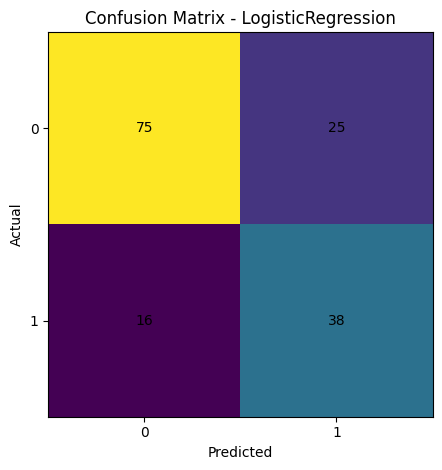

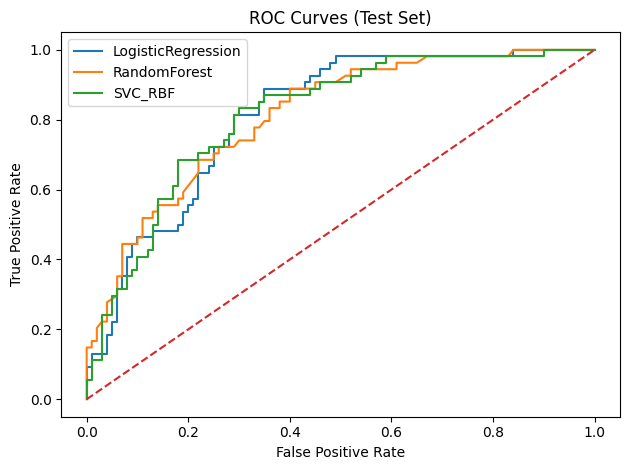

In [6]:

best_name = cv_df.iloc[0]["Model"]
best_model = candidates[best_name]
best_pipe = build_pipeline(best_model)
best_pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("BEST MODEL:", best_name)
print(f"Test Accuracy:  {acc:.4f}")
print(f"Precision:      {prec:.4f}")
print(f"Recall:         {rec:.4f}")
print(f"F1-Score:       {f1:.4f}")
print(f"ROC AUC:        {roc_auc:.4f}\n")

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title(f"Confusion Matrix - {best_name}")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.xticks([0,1], ["0", "1"]); plt.yticks([0,1], ["0", "1"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()

# ROC Curves for all models
plt.figure()
for name, model in candidates.items():
    pipe = build_pipeline(model)
    pipe.fit(X_train, y_train)
    probs = pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curves (Test Set)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.tight_layout(); plt.show()


In [7]:

# Save best pipeline to pickle
with open("diabetes_best_model.pkl", "wb") as f:
    pickle.dump(best_pipe, f)
"Saved to diabetes_best_model.pkl"


'Saved to diabetes_best_model.pkl'

In [8]:

# Quick demo prediction
numeric_cols = [c for c in df.columns if c != "Outcome"]
example_input = {col: float(df[col].median()) for col in numeric_cols}
example_df = pd.DataFrame([example_input])
pred = best_pipe.predict(example_df)[0]
proba = best_pipe.predict_proba(example_df)[0,1]
pred, proba


(np.int64(0), np.float64(0.3342020735812321))